### Gain calculator

* Calculate correctiion to the gains. 
* Write the gains to a new config.json

In [1]:
import sys
sys.path.insert(0,'python/')
import json,glob
import matplotlib.pyplot as plt
import numpy as np
# import data handling class
from DT5550 import *

#### Settings

* config file to change....
* target energy to calibrate

In [2]:
config_file = '../../DT5550_DAQ/daq/ReadoutClient/config_new.json'
Ecal = 511 # keV

Open a datafile and read the data

In [8]:
#
# open the datfile
#
#io = DT5550(file='../../data/20211213_103444/data_20211213_103444_0.raw')
indir = '../../data/20211214_100403/'
io = DT5550(indir=indir)
config_in = glob.glob(indir+'*.json')[0]
print(config_in)
#io = DT5550(file='../../DT5550_DAQ/daq/ReadoutClient/test0.raw')

E = []
for idet in range(N_DETECTOR):
    E.append([])
    
for file in io.filenames:
    io.open_data(file)
    while io.read_event() == 0:
        if io.n_event%100000 == 0:
            print('Processed ',io.n_event,' events')
        for idet in range(N_DETECTOR):
            if io.valid[idet]:
                E[idet].append(io.Q[idet])
           
print('Processing done')

DT5550:: Data recorded with config:  ../../data/20211214_100403\config_20211214_100403.json
../../data/20211214_100403\config_20211214_100403.json
DT5550:: Open data file: ../../data/20211214_100403\data_20211214_100403_0.raw
Processing done


#### do the gain correction calculations

0 correction = 1.003954386472236
1 correction = 1.0034713665827395
2 correction = 1.0022418308070806
3 correction = 1.0001337031768902
4 correction = 0.9949338909912719
5 correction = 1.0011539312419806
6 correction = 0.9986615971953315
7 correction = 1.0020901919128287


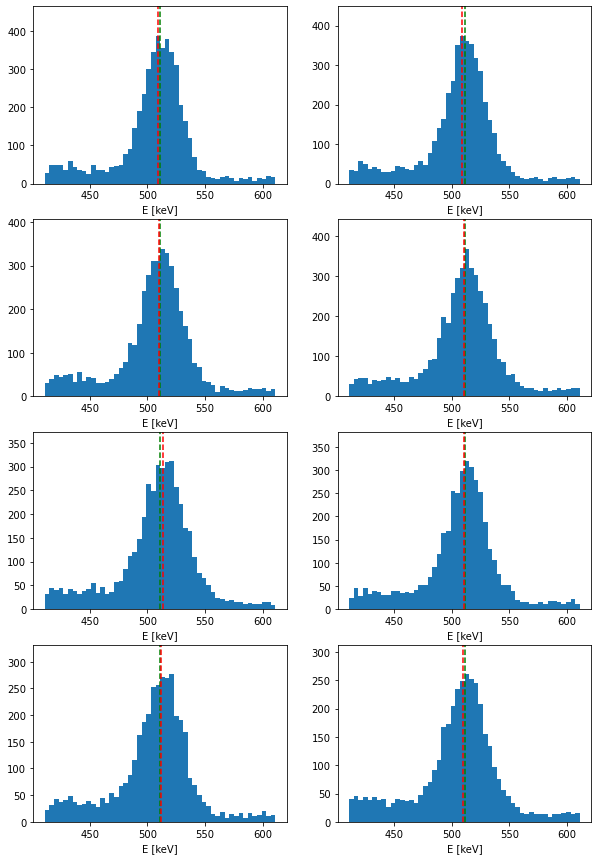

In [9]:
fig = plt.figure(figsize=(10,15))
E = np.array(E,dtype=object)
bins = 50
dE = 100

E_correction = np.zeros([N_DETECTOR])

for idet in range(N_DETECTOR):
    plt.subplot(4, 2, 1+idet)
    Edet = np.array(E[idet])
    
    val, _, _ = plt.hist(Edet[abs(Edet-Ecal)<dE],bins=bins,range=(Ecal-dE,Ecal+dE))
    idx = val.argmax()
    # calculate the peak value
    Emax = 0
    vsum = 0
    for i in range(idx-10,idx+11):
        Emax = Emax + i*val[i]
        vsum = vsum + val[i]
    Emax = (Emax/vsum)*2*dE/bins+(Ecal-dE)
    
    plt.plot([Ecal,Ecal],[0,100000],'--',color='green')
    plt.plot([Emax,Emax],[0,100000],'--',color='red')
    
    E_correction[idet] = Ecal / Emax
    print(idet,'correction =',E_correction[idet])

    plt.ylim(0,val.max()*1.2)
    plt.xlabel('E [keV]')

#### implement the gain corrections in the configuration file

In [10]:
#
# read the input json file
#
f = open(config_in,"r")
config = json.load(f)
f.close()
#
# set the BASE variable and fill it with the mean baseline for each detector
#
for idet in range(N_DETECTOR):
    print(int(config['detector_settings'][idet]['GAIN']*E_correction[idet]))
    config['detector_settings'][idet]['GAIN'] = int(config['detector_settings'][idet]['GAIN']*E_correction[idet])

415
451
522
452
408
459
505
579


In [6]:
with open(config_file,"w") as outfile:
    json.dump(config,outfile,indent=4)